# Projekt Zdjęcie Panoramiczne
przedmiot: Algebra Liniowa

pracownia specjalistyczna 9

członkowie zespołu:
- Jan Hapunik - 120316
- Izabela Rybińska - 119613


## 1. wprowadzenie teoretyczne oraz opis wykorzystanego aparatu matematycznego

Zadanie polega na stworzeniu programu będącego w stanie połaczyć przynajmniej dwa zdjęcia wykonane z tego samego miejsca, opisujące różne przestrzenie (ale z istniejącymi punktami wspólnymi) w jedno zdjęcie panoramiczne przy użyciu metod z algebry liniowej. 

### **Aby to osiągnąć potrzebujemy:**

- dwa zdjęcia, z zaznaczonymi punktami wspólnymi;
- kod umożliwiający przekształcenie zdjęć na osi trzech współrzędnych tak, by zaznaczone punkty się na siebie nakładały. Trzecia współrzędna jest używana jako waga, pozwalająca skalować obraz, więc tak naprawdę poruszamy się po osi dwóch głównych współrzędnych i jednej pomocnej;
- przycięcie końcowego zdjęcia do odpowiednich rozmiarów;

### **Część teoretyczna:**

**Narzędzia matematyczne, z których będziemy korzystać:**

- **współrzędne jednorodne**

Rozpatrujemy punkty obrazu jako elementy płaszczyzny rzutowej $\mathbb{P}^2$
opisanej współrzędnymi jednorodnymi. Pikselowi $(x, y) \in \mathbb{R}^2$
odpowiada wektor

$$
p = (x, y, 1)^T \in \mathbb{R}^3,
$$

przy czym w $\mathbb{P}^2$ obowiązuje relacja równoważności
$p \sim \lambda p$ dla dowolnego $\lambda \neq 0$.

Trzecia współrzędna jest  nośnikiem skali w reprezentacji jednorodnej; przejście z $(x, y, w)$ do współrzędnych euklidesowych odbywa się przez normalizację

$$
\pi(x, y, w) = \left( \frac{x}{w}, \frac{y}{w} \right), \qquad w \neq 0.
$$

Celem jest znalezienie przekształcenia rzutowego (homografii) $H$ takiego,
aby dla par punktów odpowiadających $p_i \leftrightarrow p'_i$ zachodziło
$$
p'_i \sim H p_i,
$$
co po normalizacji powoduje nałożenie się zaznaczonych punktów w obu obrazach.

Zastosowanie współrzędnych jednorodnych pozwala zapisać przekształcenia perspektywiczne (homografie) oraz przesunięcia (translacje) w postaci liniowej jako mnożenie przez macierz liniową 3 x 3, co nie byłoby możliwe w klasycznym układzie kartezjańskim.

- **homografia**

Homografia jest przekształceniem rzutowym $\mathbb {P}^2 \to \mathbb{P}^2$zadanym przez macierz nieosobliwą $H \in \mathbb{R}^{3\times 3}$ (określoną z dokładnością do skali), taką że

$$
p' \sim H p, \qquad
p = (x, y, 1)^T,\quad
p' = (x', y', 1)^T.
$$

Współrzędne niejednorodne otrzymuje się przez normalizację trzeciej składowej:
jeśli $H p = (x', y', w')^T$, to

$$
x' = \frac{X'}{W'}, \qquad
y' = \frac{Y'}{W'}.
$$

Po zapisaniu $H = (h_{ij})$ dostajemy postać ułamkową:

$$
x' = \frac{h_{11} x + h_{12} y + h_{13}}{h_{31} x + h_{32} y + h_{33}},\qquad
y' = \frac{h_{21} x + h_{22} y + h_{23}}{h_{31} x + h_{32} y + h_{33}}.
$$

Ponieważ $H$ jest określona do skali, ma 8 stopni swobody. Do jej wyznaczenia minimalnie potrzeba 4 par punktów odpowiadających (dających 8 niezależnych równań). Dla większej liczby punktów rozwiązanie
wyznacza się w sensie najmniejszych kwadratów, minimalizując błąd dopasowania wynikający z nadmiaru równań i szumu pomiarowego.


- **metoda najmniejszych kwadratów**

Na samym początku określając koordynaty punktów wspólnych pomiędzy dwoma obrazami wyznaczyliśmy ich o wiele więcej niż 4 pary. Gdybyśmy wzięli je wszystkie pod uwagę układ równań byłby nadokreślony. Do wyznaczenia macierzy homografii minimalizującej błąd dopasowania korzystamy z metody najmniejszych kwadratów. 

Szukamy w niej takiego wektora parametrów x (współczynników homografii), który minimalizuje normę błędu
$$ min || Ax - b ||^2 $$

Rozwiązaniem tego problemu jest układ równań normalnych
$$A^T A x = A^T b \implies x = (A^T A)^{-1} A^T b$$


## 2. Wprowadzenie techniczne

- **PIL (Pillow)** - pozwala na otworzenie i przygotowanie zdjęć wejściowych do dalszego przetwarzania, a również na transformację istniejących obrazów za pomocą metody .transform();
- **MatPlotLib** - pozwala na wyświetlanie obrazów z zaznaczonymi punktami, prezentację wyników po przekształceniach;
- **Numpy** - obliczenia macierzowe, liczenie/łączenie macierzy przekształceń, MNK.

### proces: 
1. Wczytanie obu obrazów i przygotowanie ich do obróbki (format, kanał alfa).
2. Zaznaczenie par punktów odpowiadających w obu obrazach.
3. Zbudowanie układu $Ax \approx b$ dla parametrów homografii i wyznaczenie $x$ metodą MNK.
4. Złożenie przekształceń (homografia + przesunięcie), a następnie wykonanie transformacji obrazu (warp) w PIL.
5. Przycięcie obszaru wynikowego do sensownego prostokąta (usunięcie pustego tła).
6. Sklejenie obrazów w strefie nakładania (maski + funkcja wag / blending).

## 3. Rozwiązania poszczególnych zadań projektowych

### 1. Wgranie zdjęć i ręczne wyznaczenie par koordynatów

In [1]:
# importowanie bibliotek
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# otworzenie zdjęć
img_left = Image.open("image_left.jpg")
img_right = Image.open("image_right.jpg")

# skalowanie zdjęć do szerokości 1000px, gwarantuje to szybsze działanie i mniejsze zużycie pamięci
org_width, org_height = img_left.size
scale = 1000 / org_width
new_size = (int(org_width * scale), int(org_height * scale))
img_left = img_left.resize(new_size, Image.Resampling.LANCZOS)
img_right = img_right.resize(new_size, Image.Resampling.LANCZOS)

In [3]:
# opisanie punktów wspólnych
img_left_coordinates = np.array([(2339, 399), (2992, 606), (2358, 827), (2837, 805),
(3894, 565), (3079, 992), (3907, 1421), (2561, 1540), (3699, 2382), (2997, 2648),
(3681, 2855), (3843, 2867), (2024, 1516), (2041, 936), (3888, 164)])

img_right_coordinates = np.array([(814, 307), (1550, 665), (873, 786), (1380, 834),
(2229, 748), (1526, 1038), (2235, 1470), (965, 1574), (2076, 2304), (1420, 2679),
(2061, 2723), (2188, 2708), (227, 1545), (262, 839), (2228, 411)])

# skalowanie współrzędnych punktów
img_left_coordinates = img_left_coordinates * scale
img_right_coordinates = img_right_coordinates * scale

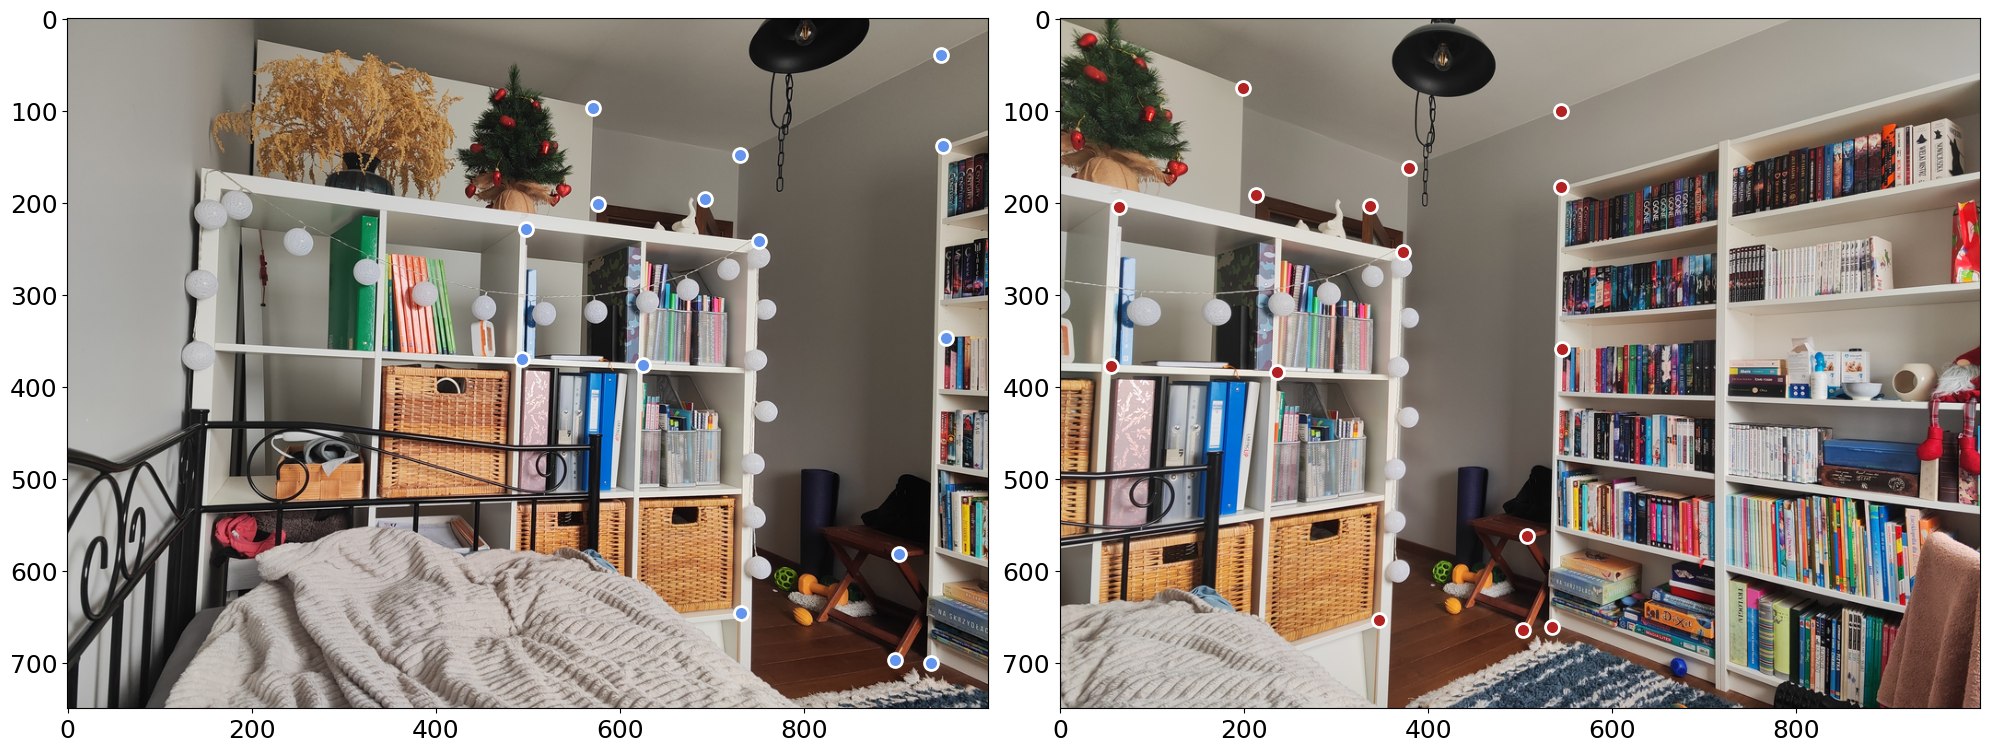

In [4]:
fig, (left, right) = plt.subplots(1, 2, figsize=(20, 10))

left.imshow(img_left)

left.scatter(img_left_coordinates[:, 0], img_left_coordinates[:, 1], 
            c='cornflowerblue', s=100, edgecolors='white', linewidths=2)
left.tick_params(axis='both', which='major', labelsize=18)

right.imshow(img_right)
right.scatter(img_right_coordinates[:, 0], img_right_coordinates[:, 1], 
            c='firebrick', s=100, edgecolors='white', linewidths=2)
right.tick_params(axis='both', which='major', labelsize=18)


plt.tight_layout()
plt.show()

### 2. Konstrukcja zdjęcia panoramicznego
#### (a) Wyznaczenie homografii

In [5]:
# kod z pliku: zdjęcie panoramiczne - notatki

def find_coefficients(source_coords, target_coords):
    tmp = []
    for src, tgt in zip(source_coords, target_coords):
        tmp.append([tgt[0],  tgt[1], 1,      0,             0, 0, -src[0]*tgt[0], -src[0]*tgt[1]])
        tmp.append([0,            0, 0, tgt[0],        tgt[1], 1, -src[1]*tgt[0], -src[1]*tgt[1]])
    a = np.matrix(tmp, dtype=float)
    b = np.array(source_coords).reshape(len(source_coords)*2)
    res = np.dot(np.linalg.inv(a.T * a) * a.T, b)
    return np.array(res).reshape(8)

coefficients to parametry homografii w kierunku: obraz źródłowy → obraz docelowy, są tutaj obliczane metodą najmniejszych kwadratów przy pomocy poniższej linijki kodu:

`res = np.dot(np.linalg.inv(a.T * a) * a.T, b)`

In [6]:
coefficients = find_coefficients(img_right_coordinates, img_left_coordinates)

Złożenie macierzy homografii:

In [7]:
homography_matrix = np.array([
    [coefficients[0], coefficients[1], coefficients[2]],
    [coefficients[3], coefficients[4], coefficients[5]],
    [coefficients[6], coefficients[7], 1.0],], dtype=float)
homography_matrix = np.linalg.inv(homography_matrix)

W bibliotece PIL funkcja `transform(..., Image.PERSPECTIVE, coeffs, ...)` działa przez mapowanie odwrotne -
dla piksela wyjściowego $(u,v)$ wyznacza ona punkt $(x,y)$ w obrazie wejściowym i z niego próbuje próbkować wartość.

Dlatego, jeśli geometria panoramy jest opisana homografią $H$, to do PIL przekazujemy w praktyce macierz $H^{-1}$.

Dla współrzędnych jednorodnych: $(x,y,1)^T \sim H^{-1}(u,v,1)^T$, po normalizacji przez trzecią składową.
Współczynniki `coeffs` kodują pierwsze dwie linie znormalizowanej macierzy $H^{-1}$ i realizują wzory
$x=\frac{a u+b v+c}{g u+h v+1},\;\; y=\frac{d u+e v+f}{g u+h v+1}$.


#### (b) Przygotowanie przestrzeni roboczej

Przy standardowej homografii istnieje możliwość, że punkty będą się znajdować w przestrzeni ujemnej, by tego uniknąć obliczamy nowe granice obrazu i stosujemy macierz translacji.

In [8]:
w1, h1 = (img_right).size
w2, h2 = (img_left).size

corners_left = np.array([[0, 0, 1], [w2, 0, 1], [w2, h2, 1], [0, h2, 1]]).T

# przemnożenie homografii przez rogi lewego obrazu 
corners_trans_left = (homography_matrix @ corners_left)
# normalizacja współrzędnych
corners_trans_left = corners_trans_left / corners_trans_left[2]

# zebranie wszystkich współrzędnych x i y
all_x = np.concatenate((corners_trans_left[0], [0, w1]))
all_y = np.concatenate((corners_trans_left[1], [0, h1]))

# obliczenie przesunięcia
shift_x = -np.min(all_x)
shift_y = -np.min(all_y)

# obliczenie rozmiaru nowego obrazu
new_w = int(np.ceil(np.max(all_x) - np.min(all_x)))
new_h = int(np.ceil(np.max(all_y) - np.min(all_y)))

Złożenie macierzy translacji:

In [9]:
translation_matrix = np.array([
    [1, 0, shift_x], 
    [0, 1, shift_y], 
    [0, 0, 1]
], dtype=float)

In [10]:
# obliczenie końcowej macierzy transformacji
final_matrix = translation_matrix @ homography_matrix

# odwrócenie macierzy i normalizacja do formatu przyjaznego dla PIL
final_matrix_inv = np.linalg.inv(final_matrix)
PIL_friendly_matrix = final_matrix_inv / final_matrix_inv[2, 2]
PIL_coeffs = PIL_friendly_matrix.flatten()[:8]

#### (c) Rozrysowanie na układzie współrzędnych.

In [11]:
# tworzymy pustą warstwę
layer1 = Image.new("RGBA", (new_w, new_h), (0, 0, 0, 0))

# wklejamy obraz panoramy
layer1.paste(img_left.convert("RGBA"), (int(shift_x), int(shift_y)))
layer2 = img_right.transform((new_w, new_h), Image.PERSPECTIVE, PIL_coeffs, Image.BICUBIC).convert("RGBA")

In [12]:
arr1_u8 = np.array(layer1, dtype=np.uint8)
arr2_u8 = np.array(layer2, dtype=np.uint8)

a1 = arr1_u8[:, :, 3] > 0
a2 = arr2_u8[:, :, 3] > 0
overlap = a1 & a2

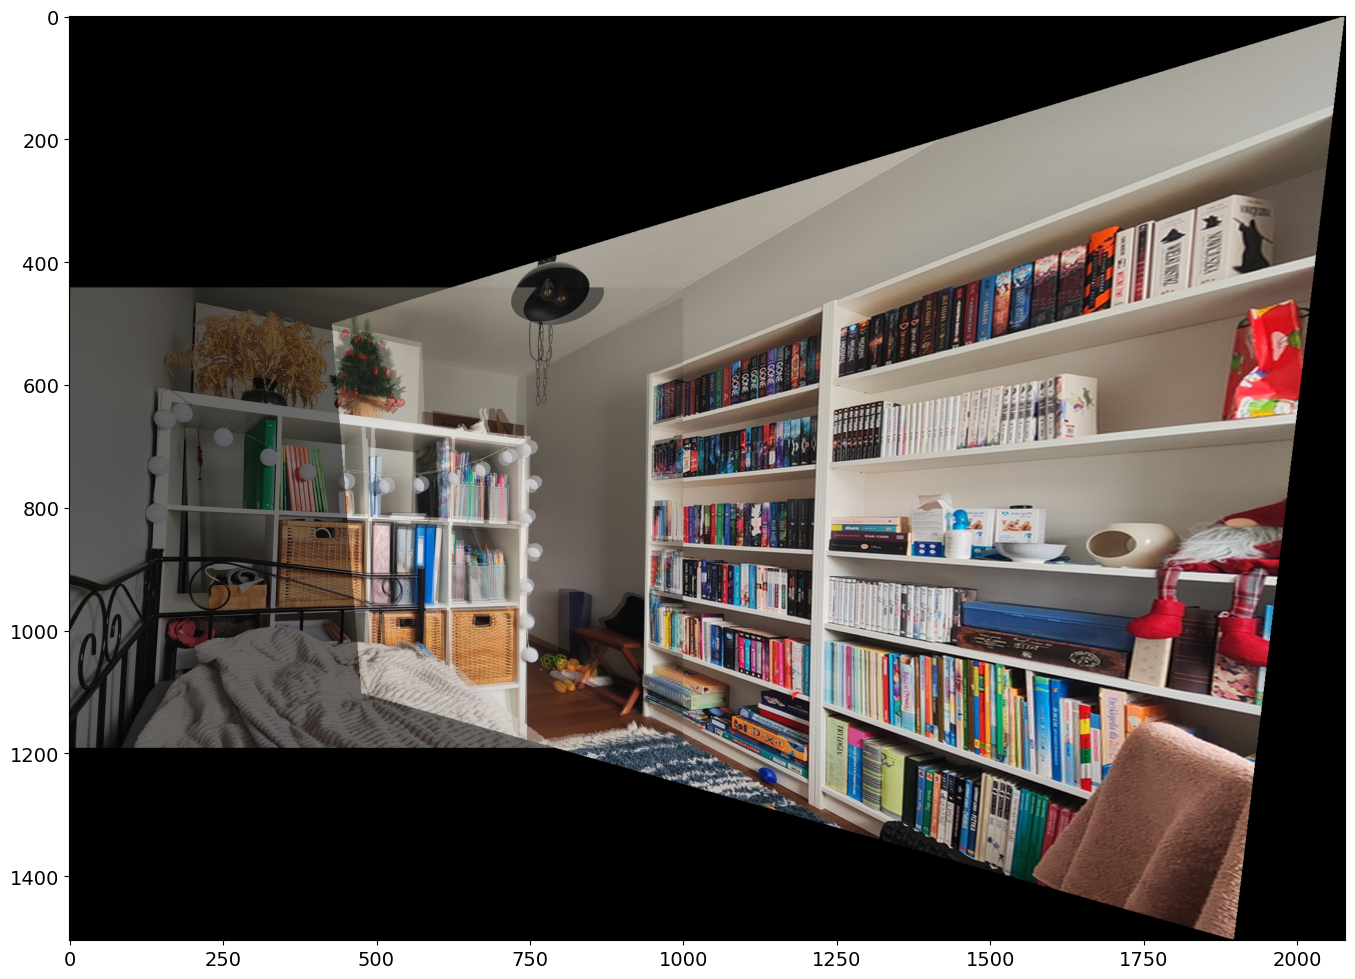

In [13]:
out = np.zeros_like(arr1_u8, dtype=np.uint8)

m = a1 & (~overlap)
out[m] = arr1_u8[m]

m = a2 & (~overlap)
out[m] = arr2_u8[m]

if np.any(overlap):
    rgb1 = arr1_u8[:, :, :3].astype(np.uint16)
    rgb2 = arr2_u8[:, :, :3].astype(np.uint16)
    avg = ((rgb1 + rgb2) >> 1).astype(np.uint8)   
    out[overlap, :3] = avg[overlap]
    out[overlap, 3] = 255

panorama_check = Image.fromarray(out, mode="RGBA")

plt.figure(figsize=(18, 12))
plt.imshow(panorama_check)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.show()



#### (d) Przycięcie panoramy

Przycięcie traktujemy jako restrykcję dziedziny obrazu do prostokąta.

Jeśli obraz jest funkcją $I:\Omega\to\{0,\dots,255\}^4$, 
to po wyznaczeniu granic $(y_s,y_e)$ oraz $x_{\text{cut}}$ dostajemy „obraz przycięty”, który definiuję:

$I_{\text{crop}} = I$ ograniczony do ${\Omega'}$, gdzie $\Omega'=[y_s,y_e)\times[0,x_{\text{cut}})$.

Tło wykrywamy przez próg jasności - liczymy jasność piksela jako sumę kanałów:

$B(i,j)=R(i,j)+G(i,j)+B(i,j)$

Następnie tworzymy maskę tła:

$\text{bg}(i,j)=\mathbf{1}\{B(i,j)<\tau\}$,

wyznaczam jako ostatnią kolumnę „nie-tła” (od prawej) w górnym i dolnym wierszu pasa.

Na koniec w górnym i dolnym wierszu badanego pasa szukam od prawej strony ostatniego piksela, który nie jest tłem, i na tej podstawie ustawiam $x_{\text{cut}}$


In [14]:
arr1_u8 = np.array(layer1, dtype=np.uint8)
arr2_u8 = np.array(layer2, dtype=np.uint8)

h_full, w_full, _ = arr1_u8.shape

y_s_calc = int(shift_y) + 2
y_e_calc = int(shift_y + h1) - 2

y_start = y_s_calc
y_end = min(h_full, y_e_calc)

strip1 = arr1_u8[y_start:y_end, :]
strip2 = arr2_u8[y_start:y_end, :]
strip_combined = np.maximum(strip1, strip2) 

pixel_brightness = (
    strip_combined[:, :, 0].astype(np.uint16) +
    strip_combined[:, :, 1].astype(np.uint16) +
    strip_combined[:, :, 2].astype(np.uint16)
)
is_background = pixel_brightness < 46

In [15]:
def find_edge_from_right(row_bool_array):
    width = len(row_bool_array)
    for x in range(width - 1, -1, -1):
        if not row_bool_array[x]:
            return x
    return 0

if is_background.shape[0] > 0:
    top_edge_x = find_edge_from_right(is_background[0, :])
    bottom_edge_x = find_edge_from_right(is_background[-1, :])
    final_cut_x = min(top_edge_x, bottom_edge_x)
    final_cut_x = min(final_cut_x + 1, w_full)
else:
    top_edge_x, bottom_edge_x = w_full, w_full
    final_cut_x = w_full

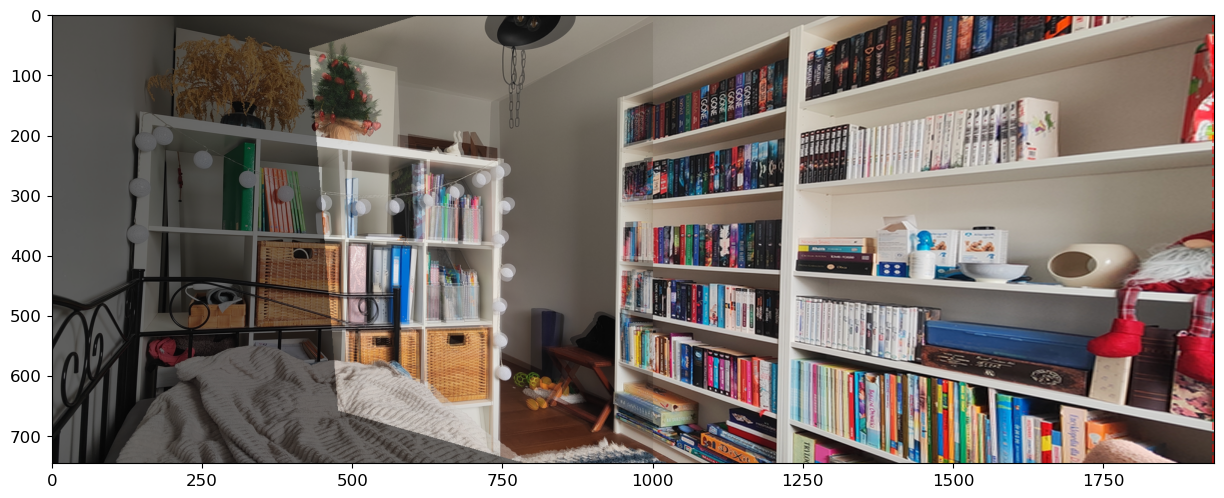

In [16]:
# Crop na uint8
arr1_u8 = arr1_u8[y_start:y_end, 0:final_cut_x].copy()
arr2_u8 = arr2_u8[y_start:y_end, 0:final_cut_x].copy()

# Podgląd po przycięciu
a1 = arr1_u8[:, :, 3] > 0
a2 = arr2_u8[:, :, 3] > 0
ov = a1 & a2

preview_u8 = np.zeros_like(arr1_u8, dtype=np.uint8)
preview_u8[a1] = arr1_u8[a1]
preview_u8[a2 & ~ov] = arr2_u8[a2 & ~ov]

if np.any(ov):
    rgb1 = arr1_u8[:, :, :3].astype(np.uint16)
    rgb2 = arr2_u8[:, :, :3].astype(np.uint16)
    avg = ((rgb1 + rgb2) >> 1).astype(np.uint8)  
    preview_u8[ov, :3] = avg[ov]
    preview_u8[ov, 3] = 255

final_panorama_view = Image.fromarray(preview_u8, mode="RGBA")


h_fin, w_fin, _ = preview_u8.shape
plt.figure(figsize=(15, 8))
plt.imshow(final_panorama_view)
plt.axvline(x=w_fin - 2, color='red', linestyle='--', alpha=0.5)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.show()


arr1 = arr1_u8.astype(np.float32) / 255.0
arr2 = arr2_u8.astype(np.float32) / 255.0

#### (e) Wyrównanie kolorów

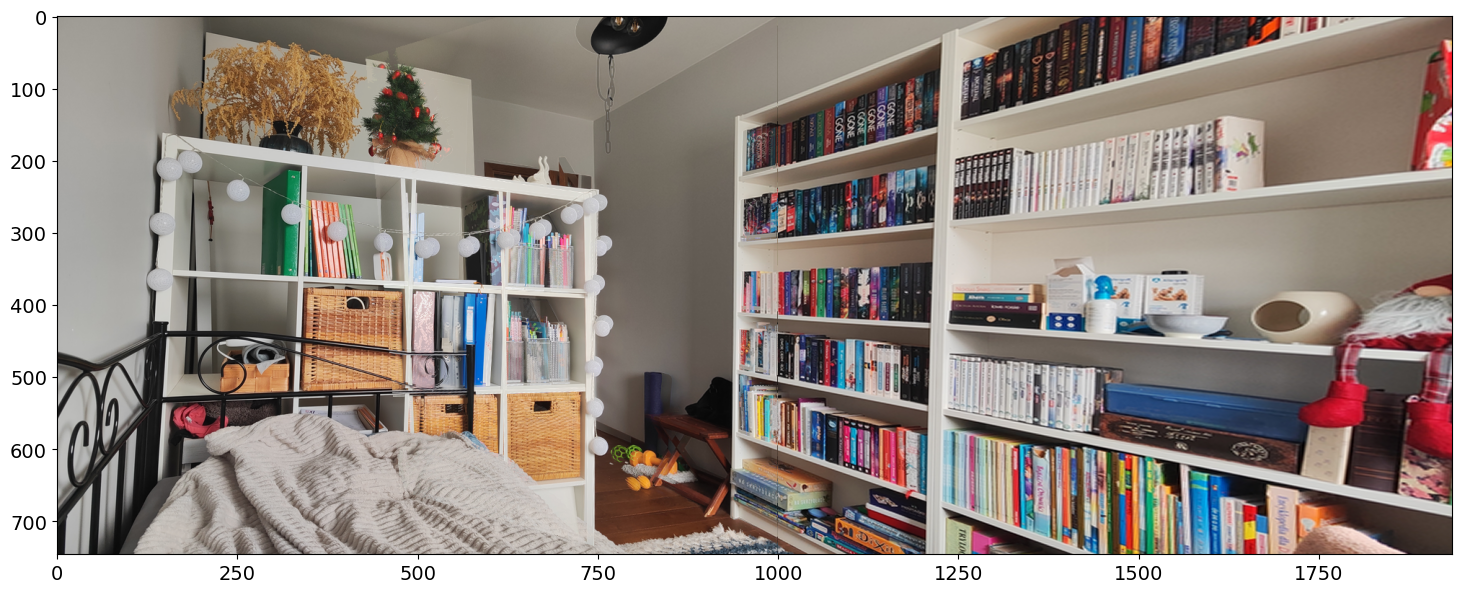

In [17]:
GAMMA_BLENDING = 30

# Pobieramy wymiary z przyciętych obrazków
nh_crop, nw_crop, _ = arr1.shape

# Maski i Overlap
mask1 = arr1[:,:,3] > 0
mask2 = arr2[:,:,3] > 0
overlap = mask1 & mask2
final = np.zeros_like(arr1)

if np.any(overlap):
    idx = np.where(np.any(overlap, axis=0))[0]
    mn, mx = idx[0], idx[-1]
    
    grad = np.linspace(0, 1, mx-mn)
    alpha = np.zeros((nh_crop, nw_crop), dtype=np.float32)
    alpha[:, mn:mx] = np.tile(grad, (nh_crop, 1))
    alpha_rgb = np.dstack([alpha]*3)
    
    # Kopiowanie stref bez nakładania
    final[mask1 & ~overlap] = arr1[mask1 & ~overlap]
    final[mask2 & ~overlap] = arr2[mask2 & ~overlap]
    
    p1_pow = np.power(arr1[:,:,:3], GAMMA_BLENDING)
    p2_pow = np.power(arr2[:,:,:3], GAMMA_BLENDING)

    w1 = 1.0 - alpha_rgb
    w2 = alpha_rgb
    
    blend = np.power(p1_pow * w1 + p2_pow * w2, 1.0 / GAMMA_BLENDING)
    
    ov3 = np.dstack([overlap]*3)
    np.copyto(final[:,:,:3], blend, where=ov3)
    final[:,:,3] = (mask1 | mask2).astype(np.float32)
else:
    final = arr1 + arr2

# wynik końcowy jako obrazek
final_panorama = Image.fromarray((final*255).astype(np.uint8))

plt.figure(figsize=(18, 12))
plt.imshow(final_panorama)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.show()

### 3. Czy istnieją metody automatycznej klasyfikacji punktów zbieżnych na obu fotografiach?

Tak, zazwyczaj się spotyka automatyczną klasyfikację punktów. Wykorzystuje się do tego algorytmy detekcji cech (feature detectors) i deskryptory, takie jak:

- SIFT - odporny na skalę i obrót
- SURF lub ORB: szybsze niż SIFT, jednak bardziej wymagający. Polega na automatycznym znalezieniu tysięcy potencjalnych punktów na obu zdjęciach, by potem znaleźć punkty wspólne. Do odrzucenia błędnego dopasowania stosuje się algorytm RANSAC. 

### 4. Jaki maksymalnie kąt możemy uchwycić korzystając z odpowiedniego rzutu na płaszczyznę? Dlaczego?

Jeżeli panorama ma powstać poprzez rzutowanie kierunków widzenia na płaszczyznę (rzut perspektywiczny/centralny na płaszczyznę obrazu),
to istnieje fundamentalne ograniczenie: da się odwzorować co najwyżej półsferę kierunków, czyli kąt widzenia ściśle mniejszy niż $180^\circ$
w danym przekroju.

Formalnie, w przekroju 2D rzut centralny na płaszczyznę w odległości ogniskowej $f$ ma postać

$$
x = f \tan \theta,
$$

gdzie $\theta$ jest kątem od osi optycznej. 

Gdy $|\theta| \to 90^\circ$, mamy $\tan \theta \to \infty$, więc obraz punktów leżących $90^\circ$ od osi „ucieka” do nieskończoności. To oznacza, że aby przedstawić pole widzenia $\ge 180^\circ$ na płaszczyźnie, potrzebna byłaby nieskończona rozpiętość obrazu. Dodatkowo kierunki z „drugiej” półsfery nie są widoczne w rzutowaniu na jedną płaszczyznę.

W praktyce, dla obrazu o skończonej szerokości $W$ i ogniskowej $f$, horyzontalny kąt widzenia spełnia

$$
\mathrm{FOV} = 2 \arctan\left(\frac{W}{2f}\right) < 180^\circ.
$$

## 4. Podsumowanie wyników oraz wnioski;

Udało nam się połączyć dwa obrazy w panoramę przy użyciu algebry liniowej (macierz homografii, transformacja współrzędnych jednorodnych) po zaznaczeniu punktów ręcznie.

## 5. Które z zadań było najtrudniejsze?

Najtrudniejszym zadaniem było końcowe znalezienie odpowiedniego sposobu blendingu obu zdjęć.